In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('/users/dasfef/AI/vib_data_new.csv')
df_err = pd.read_csv('/users/dasfef/AI/vib_data_err.csv')
print(df.head())
print(df_err.head())

     s_measuretime  s_nodeid  s_volt  s_type   s_rmsx   s_rmsy   s_rmsz  \
0  2022-11-09 9:51         0       3       8  0.47323  0.35717  0.32355   
1  2022-11-09 9:52         0       3       8  0.47376  0.35143  0.31766   
2  2022-11-09 9:53         0       3       8  0.46836  0.35561  0.31594   
3  2022-11-09 9:54         0       3       8  0.47408  0.35575  0.31676   
4  2022-11-09 9:55         0       3       8  0.48104  0.35758  0.32425   

   s_temp  s_dir  v_type  v_lvol  v_rvol  v_ldir  v_rdir       vec    seta   
0      23      0       1       1       0       0       0  0.675427  105.025  
1      23      0       1       1       0       0       0  0.669970  104.944  
2      23      0       1       1       0       0       0  0.667561  104.991  
3      23      0       1       1       0       0       0  0.672047  104.947  
4      23      0       1       1       0       0       0  0.681470  104.963  
      s_measuretime  s_nodeid  s_volt  s_type   s_rmsx   s_rmsy   s_rmsz  \
0  20

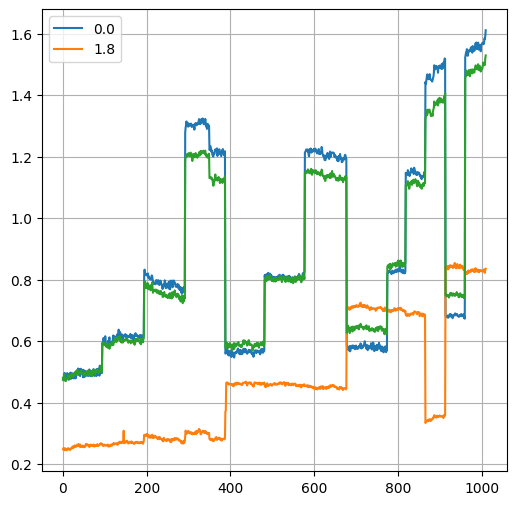

In [3]:
plt.figure(figsize = (6, 6))

plt.plot(df_err['s_rmsx'], label = 's_rmsx')
plt.plot(df_err['s_rmsy'], label = 's_rmsy')
plt.plot(df_err['s_rmsz'], label = 's_rmsz')
plt.legend([0.0, 1.8])
plt.grid()

plt.show()

In [31]:
# 문자열을 날짜 형식으로 변형
df['s_measuretime'] = pd.to_datetime(df.s_measuretime, format = '%Y-%m-%d %H:%M')
df.index = df['s_measuretime']

# 행 단위 오름차순 정렬 후 data 변수에 저장
data = df.sort_index(ascending = True, axis = 0) 


In [32]:
df_err['s_measuretime'] = pd.to_datetime(df_err.s_measuretime, format = '%Y-%m-%d %H:%M')
df_err.index = df_err['s_measuretime']

data_err = df_err.sort_index(ascending = True, axis = 0)

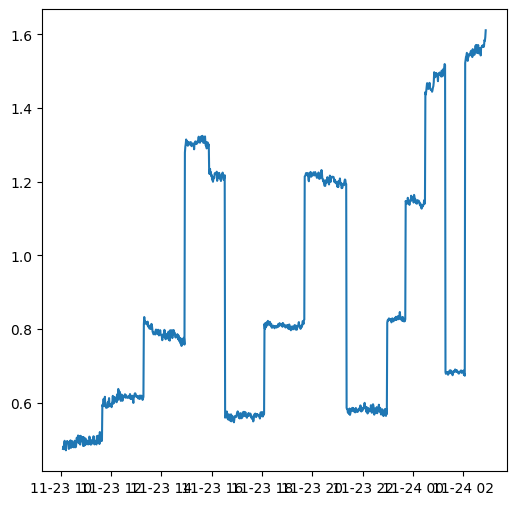

In [6]:
plt.figure(figsize = (6, 6))
plt.plot(df_err['s_rmsx'])
plt.show()

In [33]:
new_data = pd.DataFrame(index = range(0, len(df)), columns = ['s_measuretime', 's_rmsx'])

# using date, rmsx data for create dataframe
for i in range(0, len(data)) :
    new_data['s_measuretime'][i] = data['s_measuretime'][i]
    new_data['s_rmsx'][i] = data['s_rmsx'][i]

new_data.index = new_data.s_measuretime    # setting index
new_data.drop('s_measuretime', axis = 1, inplace = True)  # 조건에 맞는 열 삭제(axis = 1), 덮어쓰기 (inplace = True)
print(new_data)
new_data.shape

# make numpy array : new_data
final_data = new_data.values    # numpy 배열로 배치시킬 땐 열을 꼭 하나만 유지시키도록 해야함
print(final_data)
final_data.shape

# set 80% data for train data / set 20% for test data
print(final_data.shape[0])    # final_data 의 행 개수
train_idx = int(final_data.shape[0] * 0.8)    # 80% data set for train data
print(train_idx)
print(final_data.shape[0] - train_idx)    # 20% data set for test data


                      s_rmsx
s_measuretime               
2022-11-09 09:51:00  0.47323
2022-11-09 09:52:00  0.47376
2022-11-09 09:53:00  0.46836
2022-11-09 09:54:00  0.47408
2022-11-09 09:55:00  0.48104
...                      ...
2022-11-18 14:04:00  0.75974
2022-11-18 14:05:00  0.76098
2022-11-18 14:06:00  0.76473
2022-11-18 14:07:00  0.76853
2022-11-18 14:08:00  0.77119

[13217 rows x 1 columns]
[[0.47323]
 [0.47376]
 [0.46836]
 ...
 [0.76473]
 [0.76853]
 [0.77119]]
13217
10573
2644


In [35]:
new_data_err = pd.DataFrame(index = range(0, len(df_err)), columns = ['s_measuretime', 's_rmsx'])

for i in range(0, len(data_err)) :
    new_data_err['s_measuretime'][i] = data_err['s_measuretime'][i]
    new_data_err['s_rmsx'][i] = data_err['s_rmsx'][i]
    
new_data_err.index = new_data_err.s_measuretime
new_data_err.drop('s_measuretime', axis = 1, inplace = True)

final_data_err = new_data_err.values
print(final_data_err.shape)



(1011, 1)


In [36]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(final_data)

In [38]:
scaled_data_err = scaler.fit_transform(final_data_err)
print(scaled_data_err)

[[0.00340226]
 [0.00931236]
 [0.00261307]
 ...
 [0.97489521]
 [0.98373406]
 [1.        ]]


In [18]:
def getDataSetX(item, start, to, size) :
    arr = []
    
    for i in range(start, to - (size - 1)) :
        arr.append(item[i:i+size, 0])
    nparr = np.array(arr)
    nparr = np.reshape(nparr, (nparr.shape[0], nparr.shape[1], 1))
    return (nparr)



In [20]:
def getDataSetY(item, start, to, size) :
    arr = []
    for i in range(start + size, to + 1) :
        arr.append(item[i, 0])
    nparr = np.array(arr)
    return nparr


In [21]:
x_train = getDataSetX(scaled_data, 0, train_idx - 1, 10)
y_train = getDataSetY(scaled_data, 0, train_idx - 1, 10)

x_test = getDataSetX(scaled_data, train_idx, final_data.shape[0] - 1, 10)
y_test = getDataSetY(scaled_data, train_idx, final_data.shape[0] - 1, 10)

In [39]:
x_test_err = getDataSetX(scaled_data_err, 0, final_data_err.shape[0] - 1, 10)
y_test_err = getDataSetY(scaled_data_err, 0, final_data_err.shape[0] - 1, 10)

In [22]:
lstm_model = Sequential([ 
    LSTM(units = 10, return_sequences = True, input_shape = (x_train.shape[1], 1)),
    LSTM(units = 10),
    Dense(1)
])
lstm_model.compile(loss = 'mse', optimizer = 'adam')
lstm_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_lstm = lstm_model.fit(x_train, y_train, epochs = 20, batch_size = 32,
                             validation_split = 0.2)



Epoch 1/20


2022-12-08 15:11:21.978424: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


20/20 [==============================] - 2s 21ms/step - loss: 0.0907 - val_loss: 0.0229
Epoch 2/20
20/20 [==============================] - 0s 4ms/step - loss: 0.0228 - val_loss: 0.0231
Epoch 3/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.0108
Epoch 4/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0096
Epoch 5/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0084
Epoch 6/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0081
Epoch 7/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0088
Epoch 8/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 9/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 10/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0083
Epoch 11/20
20/20 [==========

In [24]:
pred_s_rmsx = lstm_model.predict(x_test)
pred_s_rmsx = scaler.inverse_transform(pred_s_rmsx)    # 정규화 데이터로 변환
print(pred_s_rmsx.shape)

7/7 [==============================] - 0s 1ms/step
(193, 1)


In [40]:
pred_s_rmsx_err = lstm_model.predict(x_test_err)
pred_s_rmsx_err = scaler.inverse_transform(pred_s_rmsx_err)    # 정규화 데이터로 변환
print(pred_s_rmsx_err.shape)

32/32 [==============================] - 0s 991us/step
(1001, 1)


In [25]:
test_data = final_data[train_idx : , :]    # 테스트 데이터 원본
print(test_data[10: , 0].shape)

(193,)


In [26]:
test_data = final_data[train_idx: , : ]    # 테스트 데이터 원본
print(test_data[10:, 0])    # 정답
print(pred_s_rmsx[ : , 0])    # 예측

# MAPE(Mean Absolute Percentage Error)
print(np.mean(np.abs((test_data[10:, 0] - pred_s_rmsx[:, 0]) / test_data[10:, 0])) * 100)



[0.82695 1.14778 1.14359 1.14003 1.14048 1.1414 1.15637 1.15064 1.14458
 1.14182 1.1372 1.14467 1.14964 1.14732 1.16196 1.15258 1.15253 1.15706
 1.15163 1.15945 1.14348 1.16426 1.15771 1.15228 1.15273 1.14645 1.14138
 1.1435 1.14051 1.15 1.14393 1.14471 1.14852 1.1469 1.14102 1.13673
 1.14109 1.133 1.13089 1.12692 1.13679 1.13214 1.13353 1.13734 1.13824
 1.1496 1.14003 1.14127 1.44347 1.43696 1.44571 1.45792 1.46752 1.46719
 1.45741 1.45206 1.45299 1.46126 1.46851 1.45439 1.45298 1.4493 1.44909
 1.44909 1.44432 1.44864 1.45561 1.45941 1.47037 1.49735 1.4831 1.48408
 1.48431 1.49496 1.49541 1.48942 1.48954 1.49057 1.47305 1.4936 1.48996
 1.49014 1.49655 1.49044 1.4944 1.49435 1.48555 1.50167 1.4906 1.48643
 1.49068 1.50608 1.49522 1.51071 1.51956 1.51626 0.68307 0.67847 0.68077
 0.68247 0.68087 0.68331 0.67598 0.67752 0.68144 0.68207 0.68754 0.68023
 0.68764 0.68711 0.6839 0.68086 0.68068 0.67465 0.68466 0.68499 0.68261
 0.68634 0.68729 0.69035 0.68433 0.68501 0.68866 0.68419 0.6871 0.6

In [41]:
test_data_err = final_data_err[0: , :]    # 테스트 데이터 원본
print(test_data_err[10:, 0])    # 정답
print(pred_s_rmsx_err[ : , 0])    # 예측

# MAPE(Mean Absolute Percentage Error)
print(np.mean(np.abs((test_data_err[10:, 0] - pred_s_rmsx_err[:, 0]) / test_data_err[10:, 0])) * 100)



[0.49609 0.49268 0.49368 ... 1.58261 1.59269 1.61124]
[0.5082305 0.509582  0.5107132 ... 1.5315479 1.5343622 1.5371329]
4.550517122690956


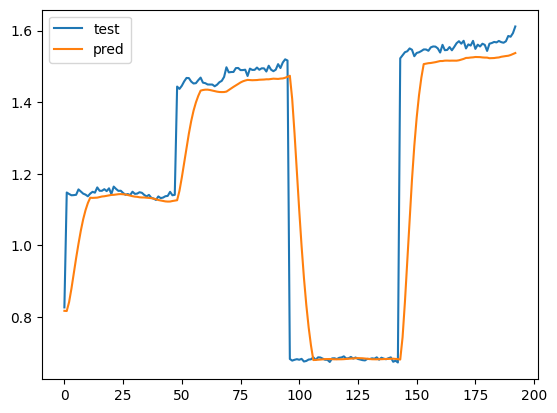

In [27]:
plt.plot(test_data1[10:, 0], label = 'test')
plt.plot(pred_s_rmsx, label = 'pred')
plt.legend()
plt.show()